In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from time import time, strftime

depth = 2
module_path = os.path.abspath('.')
sys.path.append(module_path)
for d in xrange(depth):
    module_path = os.path.abspath(os.path.join(module_path, '..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

In [3]:
% matplotlib inline
from matplotlib import pylab as pl

import seaborn as sns
import pandas as pd

In [4]:
# define paths
base_path = os.path.join(os.path.expanduser('~'), 'freqtrade')
ml_path = os.path.join(base_path, 'ml_dev')
data_path = os.path.join(ml_path, 'data')

In [5]:
# define exchange, market, and time interval
exchange = 'hitbtc'
market = 'bchbtc'
trade_interval = 1

In [6]:
# load in data
df = pd.read_csv(os.path.join(data_path, exchange, market, str(trade_interval) + 'min', 'master', 'master.csv')) 

In [7]:
from tqdm import tqdm
from datetime import datetime


# get targets
df['percent_change'] = 0.
entry_ind = 0
subtract_index = 0
look_ahead = 5
for entry in tqdm(range(len(df) - look_ahead - 1)):

    # get entry index
    entry_ind = entry - subtract_index

    # check that the two intervals are two minutes apart
    # todo: check three ahead
    if len(str(df['date'][entry_ind])) == 10:
        date_string = "%Y-%m-%d"
    else:
        date_string = "%Y-%m-%d %H:%M:%S"
    t0 = datetime.strptime(str(df['date'][entry_ind]), date_string)
    if len(str(df['date'][entry_ind + look_ahead])) == 10:
        date_string = "%Y-%m-%d"
    else:
        date_string = "%Y-%m-%d %H:%M:%S"
    t1 = datetime.strptime(str(df['date'][entry_ind + look_ahead]), date_string)

    # get difference in minutes
    diff = (t1 - t0).total_seconds() / 60.

    if diff == look_ahead:

#         # get price percentage change at t+1
#         percentage_change = (df['bid'][entry_ind + look_ahead + 1] -
#                              df['ask'][entry_ind + look_ahead]) / df['ask'][entry_ind + look_ahead]
#         df['percent_change'][entry_ind] = percentage_change
        # get price percentage change at t+1
        percentage_change = (df['close'][entry_ind + look_ahead + 1] -
                             df['close'][entry_ind + 1]) / df['close'][entry_ind + 1]
        df['percent_change'][entry_ind] = percentage_change

    else:

        # drop that entry
        df = df.drop(df.index[entry_ind])
        df = df.reset_index(drop=True)
        subtract_index += 1

print('{} Entries'.format(entry_ind))

# delete last entry as we don't have next entry to get target for
df = df.drop(df.index[len(df) - 3:])


  0%|          | 0/11568 [00:00<?, ?it/s]/Users/dan/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 11568/11568 [08:27<00:00, 22.79it/s]

11172 Entries


In [8]:
# crete copy for later
try:
    df_orig
except:
    df_orig = pd.DataFrame.copy(df)

In [9]:
print(df_orig['date'][len(df) - 1])

2017-12-16 16:13:00


In [10]:
# delete the date, buy, and buy price columns
df = df.drop('date', axis=1)
# df = df.drop('buy', axis=1)
# df = df.drop('buy_price', axis=1)
df = df.drop('ask', axis=1)
df = df.drop('bid', axis=1)
df = df.drop('last', axis=1)

In [11]:
# get input and target
start_index = 100
y = df['percent_change'].as_matrix()[start_index:]
df = df.drop('percent_change', axis=1)
x = df.as_matrix()[100:]

In [12]:
print('number of examples: {}'.format(x.shape[0]))
print('number of features: {}'.format(x.shape[1]))

number of examples: 11076
number of features: 66


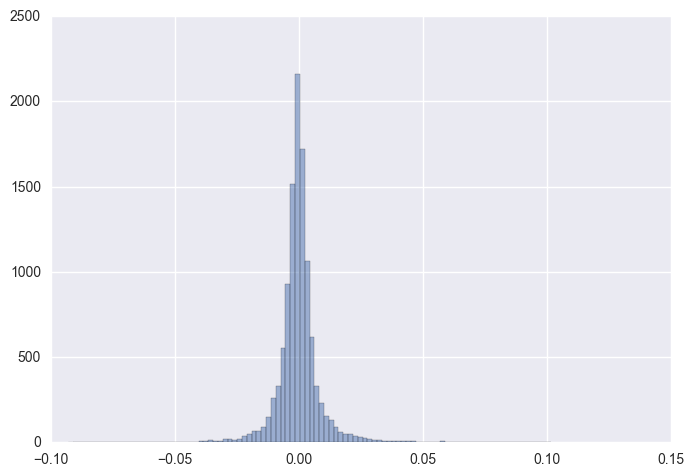

In [13]:
pl.hist(y, 100, alpha=0.5);

In [14]:
from sklearn.preprocessing import StandardScaler

# create a sclaer object
scaler = StandardScaler()

# preprocess the input data
scaler.fit(x)
x = scaler.transform(x)

In [15]:
from collections import OrderedDict

# define classes
classes = OrderedDict()
classes['loss'] = -1
# classes['same'] = 0
classes['gain'] = 1

In [16]:
from sklearn.model_selection import train_test_split

# shuffle data and perfrom train-test split
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=1 / 3., shuffle=False, random_state=0)

split_index = int(x.shape[0] * (2/3.))

X_train = x[:split_index]
y_train = y[:split_index]
X_test = x[split_index:]
y_test = y[split_index:]

In [17]:
import numpy as np

# create categorical version of y
y_train_cat = np.copy(y_train)
y_train_cat[y_train <= 0] = -1
# y_train_cat[y_train == 0] = 0
y_train_cat[y_train > 0] = 1
y_test_cat = np.copy(y_test)
y_test_cat[y_test <= 0] = -1
# y_test_cat[y_test == 0] = 0
y_test_cat[y_test > 0] = 1

In [18]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train_cat)
print(sorted(Counter(y_resampled).items()))

[(-1.0, 3915), (1.0, 3915)]


In [19]:
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

model = GradientBoostingClassifier(learning_rate=0.02, subsample=1, n_estimators=500, max_depth=2)  # n_estimators=500
# model = svm.SVC(kernel='rbf', class_weight={-1: 1, 1: 2})
# model = RandomForestClassifier(n_estimators=150, criterion='entropy', class_weight={-1: 1, 1: 1})  # class_weight={-1: 1, 0: 1, 1: 3}
model.fit(X_resampled, y_resampled)  # , sample_weight=sample_weights

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1, verbose=0,
              warm_start=False)

In [20]:
t0 = time()
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)
score = model.score(X_test, y_test_cat)
print('inference time: {}'.format(time() - t0))
print('score: {}'.format(score))

inference time: 0.0592050552368
score: 0.547941495125


In [21]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pl.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    pl.imshow(cm, interpolation='nearest', cmap=cmap)
    pl.title(title)
    pl.colorbar()
    tick_marks = np.arange(len(classes))
    pl.xticks(tick_marks, classes, rotation=45)
    pl.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pl.tight_layout()
    pl.ylabel('True label')
    pl.xlabel('Predicted label')

In [22]:
print('test loss: {} -- test same: {} -- test gain: {}'.format(
        np.sum(y_test_cat == -1), np.sum(y_test_cat == 0), np.sum(y_test_cat == 1))
     )

test loss: 1899 -- test same: 0 -- test gain: 1793


Confusion matrix, without normalization
[[1596  303]
 [1366  427]]


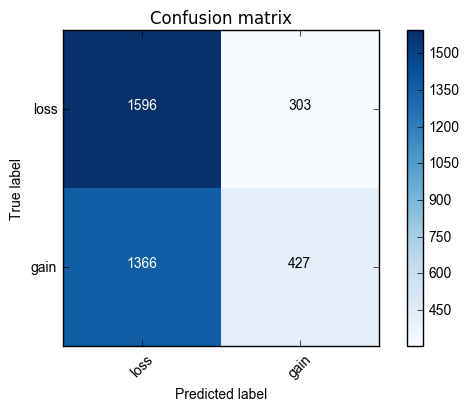

In [23]:
from sklearn.metrics import confusion_matrix
sns.reset_orig()

cm_ = confusion_matrix(y_test_cat, predictions)
plot_confusion_matrix(cm_, [key for key in classes.keys()])

In [24]:
print(y_test_cat.shape)
print(probabilities.shape)

(3692,)
(3692, 2)


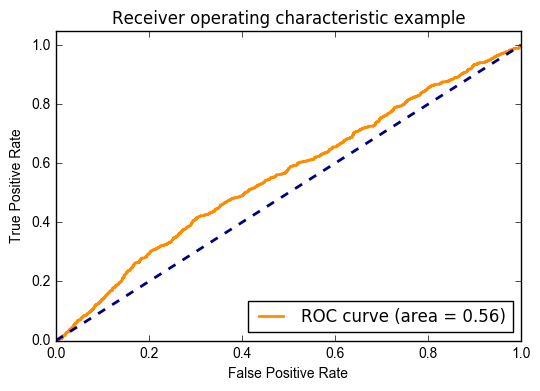

In [25]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test_cat[:], probabilities[:, 1])
roc_auc = auc(fpr, tpr)

pl.figure()
lw = 2
pl.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
pl.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
pl.xlim([0.0, 1.0])
pl.ylim([0.0, 1.05])
pl.xlabel('False Positive Rate')
pl.ylabel('True Positive Rate')
pl.title('Receiver operating characteristic example')
pl.legend(loc="lower right")
pl.show()

In [26]:
tp = []
fp = []
for ex in range(len(predictions)):
    if predictions[ex] == 1 and y_test_cat[ex] == 1:
        tp.append(y_test[ex])
    if predictions[ex] == 1 and y_test_cat[ex] == -1:
        fp.append(y_test[ex])

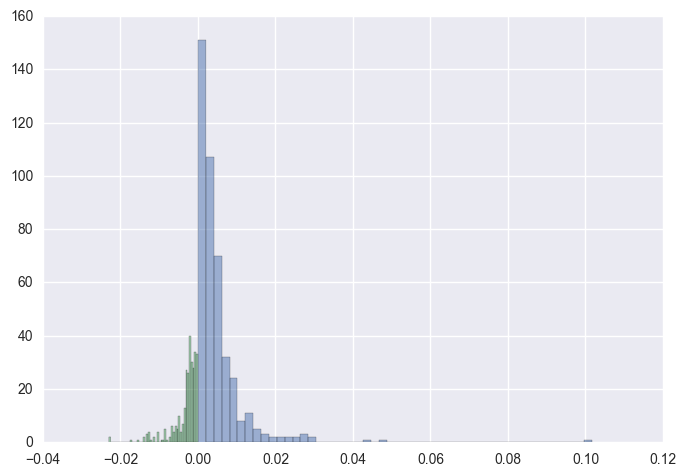

In [27]:
sns.set()
pl.hist(np.asarray(tp).flatten(), 50, alpha=0.5); 
pl.hist(np.asarray(fp).flatten(), 50, alpha=0.5);

In [28]:
# get buy-at and sell-at values
df_test = df_orig[split_index + start_index:]
df_test = df_test.reset_index(drop=True)

In [29]:
def buy_(pred):
    
    buy = False
    if pred == 1:
        buy = True
        
    return buy

In [30]:
config = {
    'stop_loss': 0.1,
    'minimum_rois': {
        "50": 0.005,
        "40":  0.01,
        "30":  0.02,
        "20":  0.03,
        "10": 0.04,
        "2": 0.05,
        "0":  0.1
    }
}

In [56]:
def get_stop_loss(x, roi, m=0.001, b=-0.2, stop=-0.05):
    
    sl = np.minimum(m * x + b, stop)
    trigger = roi < sl
    return sl, trigger

In [57]:
def get_minimum_roi(x, roi, m=-0.001, b=0.1, stop=0.005):
    
    mr = np.maximum(m * x + b, stop)
    trigger = roi > mr
    return mr, trigger

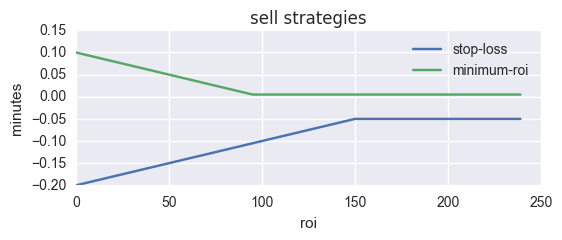

In [58]:
sl_running = []
mr_running = []
for _ in range(240):
    a, __ = get_stop_loss(_, 0)
    b, __ = get_minimum_roi(_, 0)
    sl_running.append(a)
    mr_running.append(b)

sns.set()
pl.figure(figsize=(6, 2))
pl.plot(sl_running, label='stop-loss')
pl.plot(mr_running, label='minimum-roi')
pl.legend()
pl.ylabel('minutes')
pl.xlabel('roi')
pl.title('sell strategies')

In [59]:
def calc_profit(b, s):
    
    return (s - b) / b

In [63]:
def simulate_trades(y_pred, y_true, fee=0.001, sl_m=0.001, sl_b=-0.2, mr_m=-0.001, mr_b=0.1, sl_s=-0.05, mr_s=0.005):
    
    profit = 0
    running_profit = []
    running_profit_HODL = []
    buy = 0
    sell = 0
    trade_count = 0
    trade_buffer = 0
    for trade in range(len(y_pred) - 1):
        
        # get buy signal
        buy_signal = buy_(y_pred[trade])
        
        # buy if none open and buy signal
        if buy == 0 and buy_signal:
            buy = y_true['ask'][trade]

        # else if buy open and past trade interval
        else:
        
            if trade_buffer >= trade_interval:
            
                # get sell signal 
                cur_roi = calc_profit(buy, y_true['bid'][trade])
                sl_, sl_trig = get_stop_loss(trade_buffer, cur_roi, sl_m, sl_b, sl_s)
                mr_, ml_trig = get_minimum_roi(trade_buffer, cur_roi, mr_m, mr_b, mr_s)
                buy_signal = buy_(y_pred[trade])
                if sl_trig or ml_trig:  # and not buy_signal:

                    sell = y_true['bid'][trade]
            
            trade_buffer += 1
                
        if sell !=0 and buy != 0:
            
            profit += ((sell - buy) / buy)  - (sell * fee) - (buy * fee)
            
            trade_count += 1
            buy = 0
            sell = 0
            trade_buffer = 0

        running_profit.append(profit)
        running_profit_HODL.append(
            (y_true['close'][trade + 1] - y_true['close'][0]) / y_true['close'][0]
        )
            
    avg_profit = profit / float(trade_count)
    dumb_profit = (y_true['close'][len(y_true) - 1] - y_true['close'][0]) / y_true['close'][0]
            
    return profit, avg_profit, trade_count, running_profit, running_profit_HODL, dumb_profit

In [64]:
import numpy as np

def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [65]:
# define hyperparameters
sl_m = list(np.linspace(0.0005, 0.0015, 3))
mr_m = list(np.linspace(-0.0005, -0.0015, 3))
sl_b = list(np.linspace(-0.5, -0.03, 6))
mr_b = list(np.linspace(-0.5, -0.1, 3))
sl_s = list(np.linspace(-0.05, -0.01, 5))
mr_s = list(np.linspace(0.05, 0.001, 5))
combined = cartesian((sl_m, mr_m, sl_b, mr_b, sl_s, mr_s))
hyperparameters = pd.DataFrame(combined, columns=['sl_m', 'mr_m', 'sl_b', 'mr_b', 'sl_s', 'mr_s'])
print(hyperparameters)
print(hyperparameters.ix[0])

        sl_m    mr_m  sl_b  mr_b  sl_s     mr_s
0     0.0005 -0.0005 -0.50  -0.5 -0.05  0.05000
1     0.0005 -0.0005 -0.50  -0.5 -0.05  0.03775
2     0.0005 -0.0005 -0.50  -0.5 -0.05  0.02550
3     0.0005 -0.0005 -0.50  -0.5 -0.05  0.01325
4     0.0005 -0.0005 -0.50  -0.5 -0.05  0.00100
5     0.0005 -0.0005 -0.50  -0.5 -0.04  0.05000
6     0.0005 -0.0005 -0.50  -0.5 -0.04  0.03775
7     0.0005 -0.0005 -0.50  -0.5 -0.04  0.02550
8     0.0005 -0.0005 -0.50  -0.5 -0.04  0.01325
9     0.0005 -0.0005 -0.50  -0.5 -0.04  0.00100
10    0.0005 -0.0005 -0.50  -0.5 -0.03  0.05000
11    0.0005 -0.0005 -0.50  -0.5 -0.03  0.03775
12    0.0005 -0.0005 -0.50  -0.5 -0.03  0.02550
13    0.0005 -0.0005 -0.50  -0.5 -0.03  0.01325
14    0.0005 -0.0005 -0.50  -0.5 -0.03  0.00100
15    0.0005 -0.0005 -0.50  -0.5 -0.02  0.05000
16    0.0005 -0.0005 -0.50  -0.5 -0.02  0.03775
17    0.0005 -0.0005 -0.50  -0.5 -0.02  0.02550
18    0.0005 -0.0005 -0.50  -0.5 -0.02  0.01325
19    0.0005 -0.0005 -0.50  -0.5 -0.02  

In [66]:
# find best hyperparameters
hyperparameters['roi'] = np.zeros(len(hyperparameters))
for comb in tqdm(range(len(hyperparameters))):
    curr_hp = hyperparameters.ix[comb]
    p, a_p, tc, rp, rp_hodl, dp = simulate_trades(
        predictions, df_test, sl_m=curr_hp['sl_m'], sl_b=curr_hp['sl_b'], mr_m=curr_hp['mr_m'], mr_b=curr_hp['mr_b']) 
    hyperparameters['roi'][comb] = p

100%|██████████| 4050/4050 [31:13<00:00,  2.16it/s]


In [52]:
print(hyperparameters.to_string())

       sl_m    mr_m   sl_b  mr_b       roi
0    0.0005 -0.0005 -0.500  -0.5  0.148627
1    0.0005 -0.0005 -0.500  -0.3  0.148627
2    0.0005 -0.0005 -0.500  -0.1  0.148627
3    0.0005 -0.0005 -0.406  -0.5  0.148627
4    0.0005 -0.0005 -0.406  -0.3  0.148627
5    0.0005 -0.0005 -0.406  -0.1  0.148627
6    0.0005 -0.0005 -0.312  -0.5  0.148627
7    0.0005 -0.0005 -0.312  -0.3  0.148627
8    0.0005 -0.0005 -0.312  -0.1  0.148627
9    0.0005 -0.0005 -0.218  -0.5  0.069658
10   0.0005 -0.0005 -0.218  -0.3  0.069658
11   0.0005 -0.0005 -0.218  -0.1  0.069658
12   0.0005 -0.0005 -0.124  -0.5  0.088821
13   0.0005 -0.0005 -0.124  -0.3  0.088821
14   0.0005 -0.0005 -0.124  -0.1  0.088821
15   0.0005 -0.0005 -0.030  -0.5 -0.036587
16   0.0005 -0.0005 -0.030  -0.3 -0.036587
17   0.0005 -0.0005 -0.030  -0.1 -0.036587
18   0.0005 -0.0010 -0.500  -0.5  0.148627
19   0.0005 -0.0010 -0.500  -0.3  0.148627
20   0.0005 -0.0010 -0.500  -0.1  0.148627
21   0.0005 -0.0010 -0.406  -0.5  0.148627
22   0.0005

In [67]:
i = hyperparameters['roi'].idxmax()
print(hyperparameters.ix[i])

sl_m    0.000500
mr_m   -0.000500
sl_b   -0.500000
mr_b   -0.500000
sl_s   -0.050000
mr_s    0.050000
roi     0.289408
Name: 0, dtype: float64


In [68]:
best_params = hyperparameters.ix[i]
p, a_p, tc, rp, rp_hodl, dp = simulate_trades(
    predictions, df_test,
    sl_m=best_params['sl_m'], sl_b=best_params['sl_b'], mr_m=best_params['mr_m'], mr_b=best_params['mr_b']
) 
# p, a_p, tc, rp, rp_hodl, dp = simulate_trades(
#     predictions, df_test,
#     sl_m=0, sl_b=0.001, mr_m=0, mr_b=0.001
# ) 
print("total profit made: %{} -- average trade %{} for {} trades made".format(p * 100., a_p * 100., tc))
print("profit if just HODL: %{}".format(dp * 100.))

total profit made: %28.9408422393 -- average trade %0.47444003671 for 61 trades made
profit if just HODL: %0.590332762391


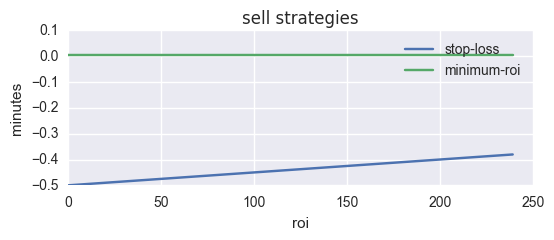

In [69]:
sl_running = []
mr_running = []
for _ in range(240):
    a, __ = get_stop_loss(_, 0, m=best_params['sl_m'], b=best_params['sl_b'])
    b, __ = get_minimum_roi(_, 0, m=best_params['mr_m'], b=best_params['mr_b'])
    sl_running.append(a)
    mr_running.append(b)

sns.set()
pl.figure(figsize=(6, 2))
pl.plot(sl_running, label='stop-loss')
pl.plot(mr_running, label='minimum-roi')
pl.legend()
pl.ylabel('minutes')
pl.xlabel('roi')
pl.title('sell strategies')

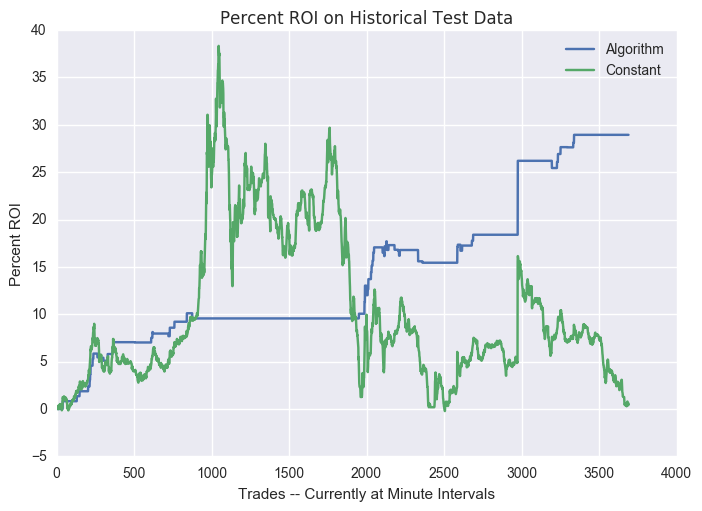

In [70]:
sns.set()

pl.plot(np.asarray(rp) * 100., label='Algorithm')
pl.plot(np.asarray(rp_hodl) * 100., label='Constant')
pl.xlabel('Trades -- Currently at Minute Intervals')
pl.ylabel('Percent ROI')
pl.title('Percent ROI on Historical Test Data')
pl.legend()

In [148]:
def trades_a_day(trade_interval=120):
    
    seconds_per_day = 60 * 60 * 24
    return seconds_per_day / float(trade_interval)

In [149]:
n_trades_possible = float(y_test_cat.shape[0])
percent_trading = tc / n_trades_possible * 100.
print('percent of possible trades made: %{}'.format(percent_trading))

percent of possible trades made: %1.65222101842


In [150]:
potential_trades_per_day = trades_a_day(trade_interval=60)
trades_day_scaler = potential_trades_per_day / n_trades_possible
percentage_per_day = trades_day_scaler * p
print('profit made per day: %{}'.format(percentage_per_day * 100.))

profit made per day: %11.2878691291


In [213]:
btc_usd_value = 10000
stake_init = 0.1
max_stake = 1
stake = stake_init
trade_days = 30 * 12
btc = stake
stake_update_interval = 30
for day in range(trade_days):
    
    if day % stake_update_interval == 0 and stake < max_stake:
        stake = btc
        if stake > max_stake:
            stake = max_stake
    
    btc += stake * percentage_per_day

btc_profit = btc - stake_init
usd_profit = btc_profit * btc_usd_value
print('using intial stake value of {} BTC / ${} USD -- and final stake  value of {} BTC / ${} USD'.format(
        stake_init, stake_init * btc_usd_value, stake, stake * btc_usd_value
))
print('btc after {} days = {} BTC / ${} USD -- update stake every {} days'.format(
        trade_days, btc_profit, usd_profit, stake_update_interval
    ))

using intial stake value of 0.1 BTC / $1000.0 USD -- and final stake  value of 1 BTC / $10000 USD
btc after 360 days = 35.6876234403 BTC / $356876.234403 USD -- update stake every 30 days


In [61]:
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# model = GradientBoostingClassifier(learning_rate=0.02, subsample=1, n_estimators=500, max_depth=2)  # n_estimators=500
# model = svm.SVC(kernel='rbf', class_weight={-1: 1, 1: 2})
model = GradientBoostingRegressor(n_estimators=1000, loss='huber')  # class_weight={-1: 1, 0: 1, 1: 3}
model.fit(X_train, y_train)  # , sample_weight=sample_weights

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [62]:
t0 = time()
predictions = model.predict(X_test)
score = model.score(X_test, y_test)
print('inference time: {}'.format(time() - t0))
print('score: {}'.format(score))

inference time: 0.119910955429
score: -8.16417216157


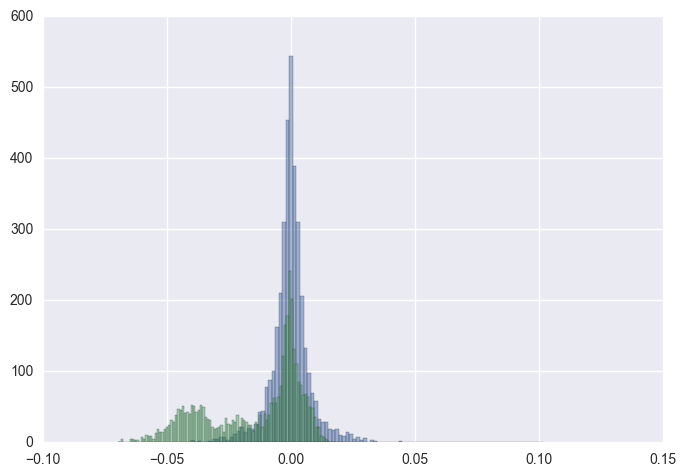

In [63]:
pl.hist(y_test, 100, alpha=0.5);
pl.hist(predictions, 100, alpha=0.5);

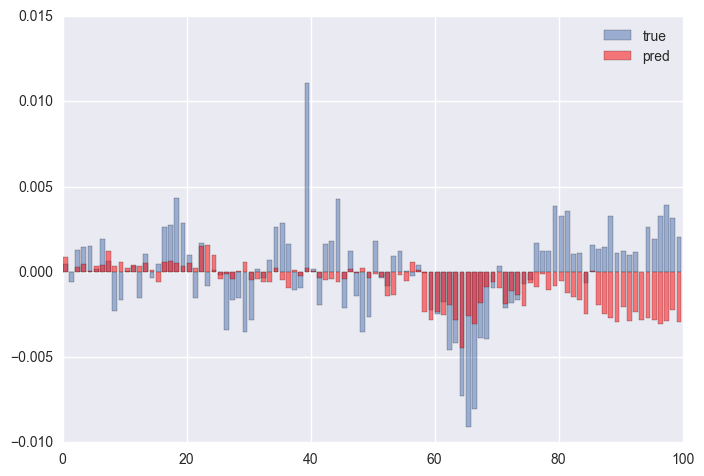

In [64]:
examples = 100
x = np.arange(examples)
pl.bar(x, y_test[:examples], alpha=0.5, label='true')
pl.bar(x, predictions[:examples], alpha=0.5, label='pred', color='red')
pl.legend()

In [65]:
p, a_p, tc, rp, rp_cb = simulate_trades(predictions > 0., df_test) # y_test
print("total profit made: %{} -- average trade %{} for {} trades made".format(p * 100., a_p * 100., tc))

total profit made: %3.62477746269 -- average trade %0.144991098508 for 25 trades made


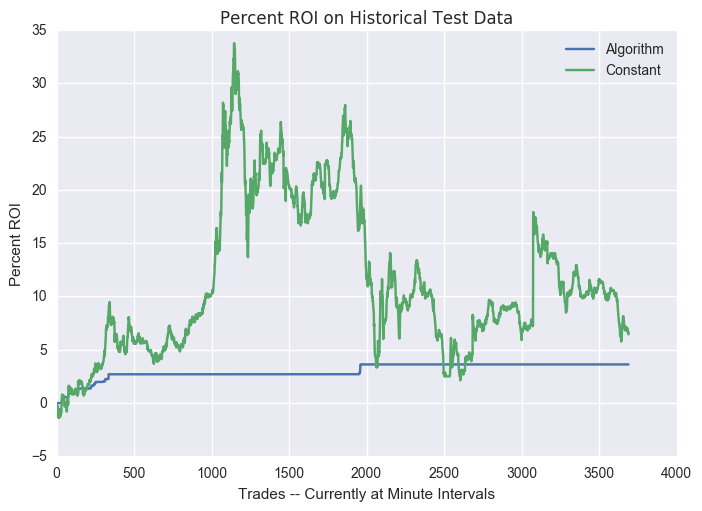

In [66]:
sns.set()

pl.plot(np.asarray(rp) * 100., label='Algorithm')
pl.plot(np.asarray(rp_cb) * 100., label='Constant')
pl.xlabel('Trades -- Currently at Minute Intervals')
pl.ylabel('Percent ROI')
pl.title('Percent ROI on Historical Test Data')
pl.legend()

In [163]:
# TRAIN ON ALL DATA

# create categorical version of y
y_cat = np.copy(y)
y_cat[y <= 0] = -1
# y_cat[y == 0] = 0
y_cat[y > 0] = 1

# resample
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(x, y_cat)

# model = RandomForestClassifier(n_estimators=150, criterion='entropy', class_weight={-1: 1, 0: 1, 1: 2})
model.fit(X_resampled, y_resampled)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.02, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=None, subsample=1, verbose=0,
              warm_start=False)

In [164]:
def date_string():
    """Get a string representation of the current local date and time.

    Format: "YYYY-mm-dd_HH-MM"

    :return: the current local date and time
    :rtype: string
    """
    return strftime("%Y-%m-%d_%H-%M")

In [165]:
import pickle

# store pipeline in dictionary
pipeline = {
    'model': model,
    'scaler': scaler
}

# save pipeline
model_fn = os.path.join(ml_path, 'models', date_string() + '.pkl')
with open(model_fn, 'wb') as f:
    pickle.dump(pipeline, f, 2)
f.close()

In [166]:
import glob

# load pipeline
model_path = os.path.join(
    os.path.expanduser('~'),
    'freqtrade',
    'ml_dev',
    'models'
)
list_of_files = glob.glob(os.path.join(model_path, '*.pkl'))
latest_file = max(list_of_files, key=os.path.getctime)
with open(latest_file, 'rb') as f:
    pipeline = pickle.load(f)
f.close()